In [1]:
import os
import glob
import pickle
import datetime
import numpy as np
from tqdm.notebook import tqdm_notebook, trange
from astropy.io import fits
from photutils import DAOStarFinder, CircularAperture
import photutils.psf
import matplotlib.pyplot as plt
from astropy.visualization import LogStretch, AsinhStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.signal import peak_widths
import astropy.units as u
import pandas as pd
from scipy import stats
from calibFuncs import *
from circlesym import *

In [2]:
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'

In [3]:
uniques, VisAO_science, VisAO_darks = sortData(datadir, instrument='VisAO', filesdeep='*\\*\\', returntab=True)

  0%|                                                                              | 15/33363 [00:00<03:51, 144.23it/s]

sorting individual images


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 191.01it/s]

sorting unique datasets into lists


In [4]:
# data takes a long time to sort so pickle result
filename = 'visao_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_science,outfile)
outfile.close()

filename = 'visao_uniques.pkl'
outfile = open(filename,'wb')
pickle.dump(uniques,outfile)
outfile.close()

filename = 'visao_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_darks,outfile)
outfile.close()

In [3]:
# read in pickle
infile = open('visao_science.pkl','rb')
VisAO_science = pickle.load(infile)
infile.close()

infile = open('visao_uniques.pkl','rb')
uniques = pickle.load(infile)
infile.close()

infile = open('visao_darks.pkl','rb')
VisAO_darks = pickle.load(infile)
infile.close()

In [4]:
# sorts dark fields into a subfolder in their directory named dark
VisAO_new_darks = []
for i in range(len(VisAO_darks)):
    dataset = VisAO_darks[i]
    new_darkset = []
    for dark_im in dataset:
        imname = dark_im.split('\\')[-1]
        newroot = dark_im.replace(dark_im.split('\\')[-1], 'dark\\')
        if os.path.exists(newroot):
            pass
        else:
            os.mkdir(newroot)
        newpath = newroot+imname
        try:
            os.rename(dark_im, newpath)
        except FileNotFoundError:
            pass
        new_darkset.append(newpath)
    VisAO_new_darks.append(new_darkset)

filename = 'visao_new_darks.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_darks,outfile)
outfile.close()

In [5]:
# introduce median combine function
def mediancombine(filelist, norm=False):
    '''
    median combine frames, can norm for flats or not
    '''
    # gather some information about the images
    n = len(filelist)
    first_frame_data = fits.getdata(filelist[0])
    imsize_y, imsize_x = first_frame_data.shape
    # construct an empty cube with proper dimensions
    fits_stack = np.zeros((imsize_y, imsize_x, n))
    # fill cube with images in filelist
    for ii in range(0, n):
        im = fits.getdata(filelist[ii])
        if norm is True:
            im /= np.nanmedian(im)
        fits_stack[:, :, ii] = im
    # take the median combination of the images along the
    # correct axis (we made this the 3rd axis of our image cube)
    med_frame = np.nanmedian(fits_stack, axis=2)
    return med_frame

In [6]:
# sorts science images into a subfolder in their directory named science
VisAO_new_science = []
for i in trange(len(VisAO_science)):
    dataset = VisAO_science[i]
    exptimes = []
    # print('checking exp times')
    for im in tqdm_notebook(dataset):
        try:
            im_expt = fits.getheader(im)['EXPTIME']
            if im_expt not in exptimes:
                exptimes.append(im_expt)
        except FileNotFoundError:
            pass
                
    for expt in tqdm_notebook(exptimes):
        ims_with_expt = []
        ims_with_expt_new_path = []
        for im in dataset:
            try:
                im_expt = fits.getheader(im)['EXPTIME']
                if im_expt == expt:
                    ims_with_expt.append(im)
            except FileNotFoundError:
                pass
            

        for sci_im in tqdm_notebook(ims_with_expt):
            imname = sci_im.split('\\')[-1]
            newroot = sci_im.replace(sci_im.split('\\')[-1], 'science'+str(round(expt, 5))+'s\\')
            if os.path.exists(newroot):
                # print('folder ', newroot, 'exists')
                pass
            else:
                # print('creating folder ', newroot)
                os.mkdir(newroot)
            newpath = newroot+imname
            try:
                os.rename(sci_im, newpath)
            except FileNotFoundError:
                pass
            ims_with_expt_new_path.append(newpath)
        VisAO_new_science.append(ims_with_expt_new_path)

filename = 'visao_new_science.pkl'
outfile = open(filename,'wb')
pickle.dump(VisAO_new_science,outfile)
outfile.close()

In [7]:
infile = open('visao_new_science.pkl','rb')
VisAO_new_science = pickle.load(infile)
infile.close()

infile = open('visao_new_darks.pkl','rb')
VisAO_new_darks = pickle.load(infile)
infile.close()

In [8]:
nights = glob.glob(datadir+'\\**\\')#, recursive=True)
obs = []
for night in nights:
    runs = glob.glob(night+'\\**\\')
    for run in runs:
        obs.append(run)

darks = []
obs2 = []
for ob in obs:
    exptsets = glob.glob(ob+'science*\\*fits*')
    if len(exptsets) != 0:
        obs2.append(exptsets)
        darkset = glob.glob(ob+'dark*\\*fits*')
        darks.append(darkset)

In [9]:
# write master dark for each observation
master_darks = []
master_dark_paths = []
for obs in tqdm_notebook(darks):
    darkim = obs[0]
    oldheader = fits.getheader(darkim)
    oldroot = darkim.replace('dark\\'+darkim.split('\\')[-1], '\\')
    newpath = oldroot+'MasterDark'+str(oldheader['EXPTIME'])+'s'+str(oldheader['V47GAIN'])+'.fit'
    master_dark_paths.append(newpath)
    master_dark = mediancombine(obs)
    master_darks.append(master_dark)
    fits.writeto(newpath, master_dark, oldheader, overwrite=True)

In [11]:
# fix 2015 baades window imgs
windows = []
for dataset in obs2:
    if 'baade' in dataset[0]:
        windows.append(dataset)

for dataset in windows[0:1]:
    first_frame, first_header = fits.getdata(dataset[0], header=True)
    n = len(dataset)
    imsize_y, imsize_x = first_frame.shape
    for ii in trange(0, n):
        empty_img = np.zeros((imsize_y, imsize_x))
        im, hdr = fits.getdata(dataset[ii], header=True)
        if ii < 8:
            empty_img[497:512, :] = im[0:15, :]
            empty_img[512:526, :] = im[1010:1025, :]
            empty_img[0:497, :] = im[15:512]
            empty_img[526:, :] = im[512:1010, :]
            fits.writeto(dataset[ii], empty_img, header=hdr, overwrite=True)
        else:
            pass

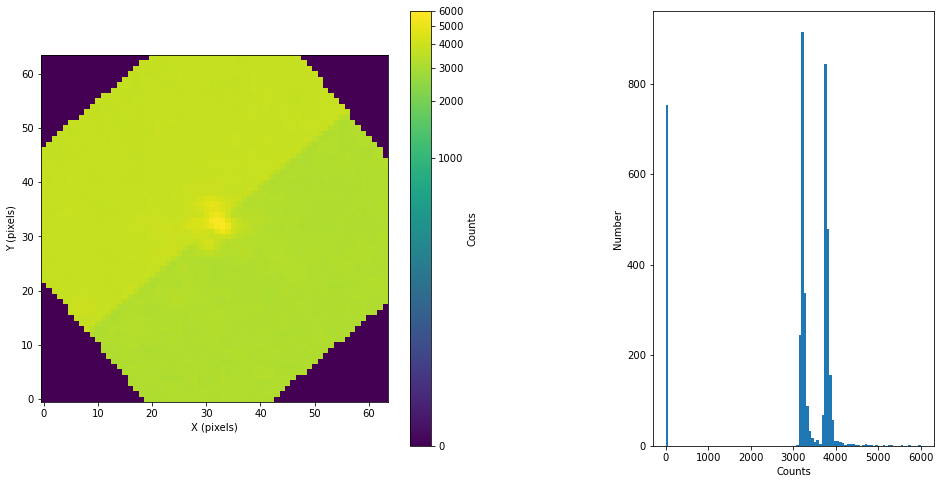

In [35]:
# concerning stability of GRV rotator mode over time
diffs = []
for i in trange(1):
    sci_ims = obs2[i]
    dark_ims = darks[i]
    dark = master_darks[i]
    firstim = sci_ims[0]
    try:
        first_frame_data, firstheader = fits.getdata(firstim, header=True)
        date = firstheader['DATE-OBS'].split('T')[0]
        targ = firstheader['OBJECT']
        expt = firstheader['EXPTIME']
        rotoff0 = firstheader['ROTOFF']
#         newroot = firstim.replace('\\science'+str(round(expt, 5))+'s\\'+firstim.split('\\')[-1], '\\')
#         newpath = newroot+targ+'_'+date+'_'+'darksub_cube.fit'

        n = 1#len(sci_ims)
        imsize_y, imsize_x = first_frame_data.shape
        fits_stack = np.zeros((n, imsize_y, imsize_x))
        for ii in range(0, n):
            img, hdr = fits.getdata(sci_ims[ii], header=True)
            rotoffii = float(hdr['ROTOFF'])
            rotim = rotate(img, rotoffii+90.0, [imsize_x//2, imsize_y//2])
            imgandhist(rotim)
    except FileNotFoundError:
        pass

# print('median rotoff diff:',np.median(diffs))
# print('max rotoff diff:',np.max(diffs))
# print('min rotoff diff:',np.min(diffs))

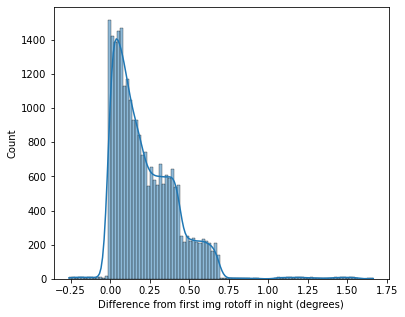

In [27]:
import seaborn as sb
plt.figure(figsize=(6,5))
sb.histplot(diffs, kde=True)
plt.xlabel('Difference from first img rotoff in night (degrees)')
plt.savefig('Rotoff-diff-dist.png', dpi=300)

In [12]:
# dark subtract and save as cube

import warnings
warnings.filterwarnings("ignore")

for i in trange(len(obs2)):
    sci_ims = obs2[i]
    dark_ims = darks[i]
    dark = master_darks[i]
    firstim = sci_ims[0]
    try:
        first_frame_data, firstheader = fits.getdata(firstim, header=True)
        date = firstheader['DATE-OBS'].split('T')[0]
        targ = firstheader['OBJECT']
        expt = firstheader['EXPTIME']
        
        n = len(sci_ims)
        imsize_y, imsize_x = first_frame_data.shape
        fits_stack = np.zeros((n, imsize_y, imsize_x))
        newroot = firstim.replace('\\science'+str(round(expt, 5))+'s\\'+firstim.split('\\')[-1], '\\')
        if firstheader['VWOLLSTN'] == 'IN':
            if first_frame_data.shape[1] >= 1024:
                for ii in range(0, n):
                    im = fits.getdata(sci_ims[ii])
                    fits_stack[ii] = im - dark
                ha = fits_stack[:, 513:, :]
                ha_off = fits_stack[:, 0:512, :]
                newhapath = newroot+targ+'Ha_'+date+'_'+'darksub_cube.fit'
                newcontpath = newroot+targ+'Cont_'+date+'_'+'darksub_cube.fit'

                for images in [ha, ha_off]:
                    for ii in range(0, n):
                        hdr = fits.getheader(sci_ims[ii])
                        rotoffii = hdr['ROTOFF']
                        im = images[ii]
                        images[ii] = rotate(im, rotoffii+90.0, [imsize_x//2, imsize_y//4]) # rotate to approx north up  

                fits.writeto(newhapath, ha, firstheader, overwrite=True)
                fits.writeto(newcontpath, ha_off, firstheader, overwrite=True)
                

            else:
                for ii in range(0, n):
                    im, hdr = fits.getdata(sci_ims[ii], header=True)
                    rotoffii = hdr['ROTOFF']
                    im = im - dark  # dark subtraction step
                    fits_stack[ii] = rotate(im, rotoffii+90.0, [imsize_x//2, imsize_y//2]) # rotate to approx north up
                newpath = newroot+targ+'_'+date+'_'+'darksub_cube.fit'
                fits.writeto(newpath, fits_stack, firstheader, overwrite=True)
        else:
            for ii in range(0, n):
                im, hdr = fits.getdata(sci_ims[ii], header=True)
                rotoffii = hdr['ROTOFF']
                im = im - dark  # dark subtraction step
                fits_stack[ii] = rotate(im, rotoffii+90.0, [imsize_x//2, imsize_y//2]) # rotate to approx north up
            newpath = newroot+targ+'_'+date+'_'+'darksub_cube.fit'
            fits.writeto(newpath, fits_stack, firstheader, overwrite=True)

        # delete raw data to save space
        for im in sci_ims:
            os.remove(im)
        for dark in dark_ims:
            os.remove(dark)

    except FileNotFoundError:
        pass

In [1]:
from calibFuncs import *
from circlesym import *

# read in dark subtracted images
datadir = 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\William\\trapezium_data\\visao_astro'
darksubs = glob.glob(datadir+'\\**\\*darksub_cube.fit', recursive=True)

def imgandhist(img, log=False, a=0.01):
    from astropy.stats import sigma_clip
    fig = plt.figure(figsize=(16,8))
    ax1 = plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3)
    im_frame = ax1.imshow(img, norm=ImageNormalize(stretch=AsinhStretch(a=a)), origin='lower')
    ax1.set_xlabel('X (pixels)')
    ax1.set_ylabel('Y (pixels)')
    plt.colorbar(im_frame, ax=ax1, label='Counts')
    ax2 = plt.subplot2grid((3,6), (0,4), rowspan=3, colspan=2)
    ax2.hist(sigma_clip(img.flatten(), sigma=10), bins=100)
    ax2.set_xlabel('Counts')
    ax2.set_ylabel('Number')
    if log:
        ax2.set_xscale('log')
    plt.show()

In [9]:
# GOOD
# baades 2015 darksubs
# theba b broadband 2016 darksubs[19:22]
# theta b broadband 2018 darksubs darksubs[40:42]

# ROUGH

['C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20161116_17\\tet1OriB_ip_350modes_20161117073420226445\\Theta1_Ori_C_2016-11-17_darksub_cube.fit',
 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20161116_17\\tet1OriB_zp_350modes_20161117072924185566\\Theta1_Ori_C_2016-11-17_darksub_cube.fit',
 'C:\\Users\\willi\\Dropbox (Amherst College)\\Research\\Follette-Lab\\Thesis-Data\\William\\trapezium_data\\visao_astro\\visao_20161116_17\\tet1OriB_zp_350modes_20161117073136006316\\Theta1_Ori_C_2016-11-17_darksub_cube.fit']

current darksubs ind is 19


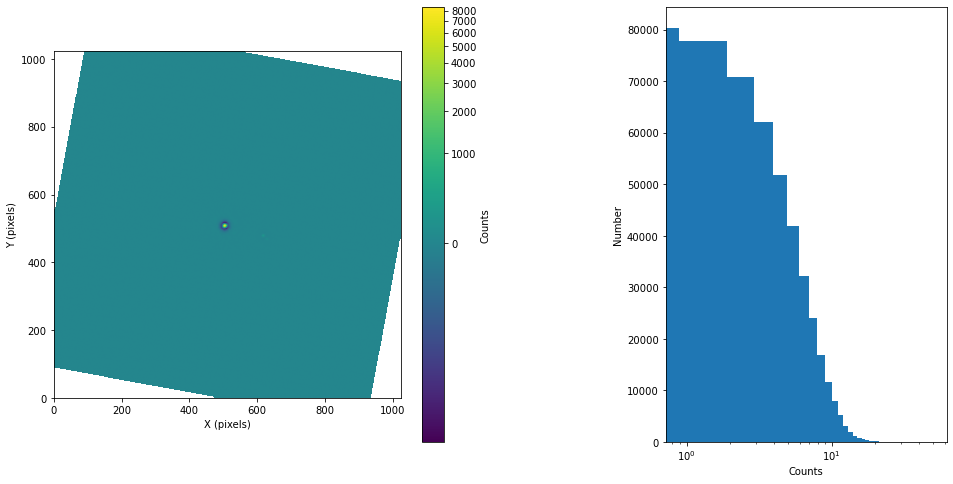

type 'skip' to skip, else type 'go': go


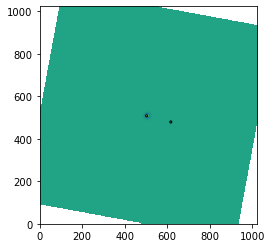

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
 616.9157389917432 479.00216050427485 0.09259778963913116
503.17711256585835 508.11252318693795 0.08287758650080422
input the 0 indexed integer of your target from the table above: 1
target star is at  503 , 508  at FWHM 5.937871227178164
503 508
give boxsize: 451



Max x-shift=46.38247365863555, max y-shift=307.2576366390597 (pixels)

 Done stacking!


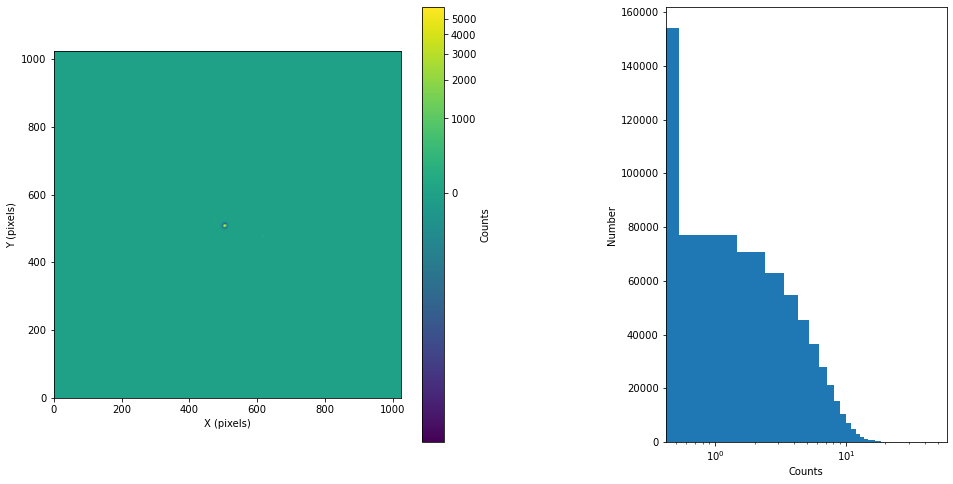

running circular symmetry on:  Theta1_Ori_C_2016-11-17_darksub_cube.fit
503 508 225
dimensions of Data: (250, 450, 450)
100
Out of 51 rows, this many have finished: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 
[[ -910359.41321963  -891265.9826977   -819894.37304264 ...
  -1726572.59642157 -1391217.88103059 -1153063.03796782]
 [-1645877.73013918 -1133905.67629233  -930156.53402011 ...
  -1490980.90842028 -1301414.77864119 -1325404.79960885]
 [ -855311.69489534 -1046766.24551902  -817850.87932203 ...
  -1253318.50569409 -1092505.6614506   -899658.6082273 ]
 ...
 [-1240494.26157601 -1530559.47663805 -1605434.72046393 ...
   -565161.66479074  -744360.99316005  -629867.40584654]
 [-1116693.21190805 -1169164.58272606 -1525275.03447906 ...
   -538550.48761917  -665190.05613309  -742331.86104187]
 [ -921398.3190863  -1457147.9138771  -1364091.11

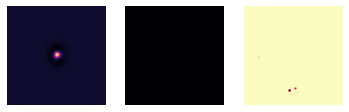

centroid_1dg center: 18.73342735577826 -19.970623843948864

median center of circular symmetry is:  43.23342735577826 4.529376156051136
median shift all images by:  6.266572644221739 44.970623843948864



----------- o -------------

subdiv into sections len: 125
current darksubs ind is 20


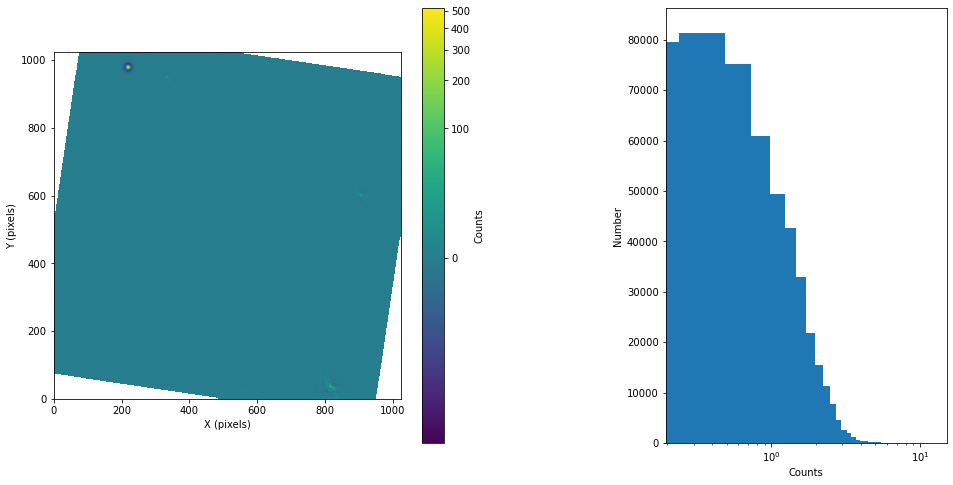

type 'skip' to skip, else type 'go': skip
current darksubs ind is 21


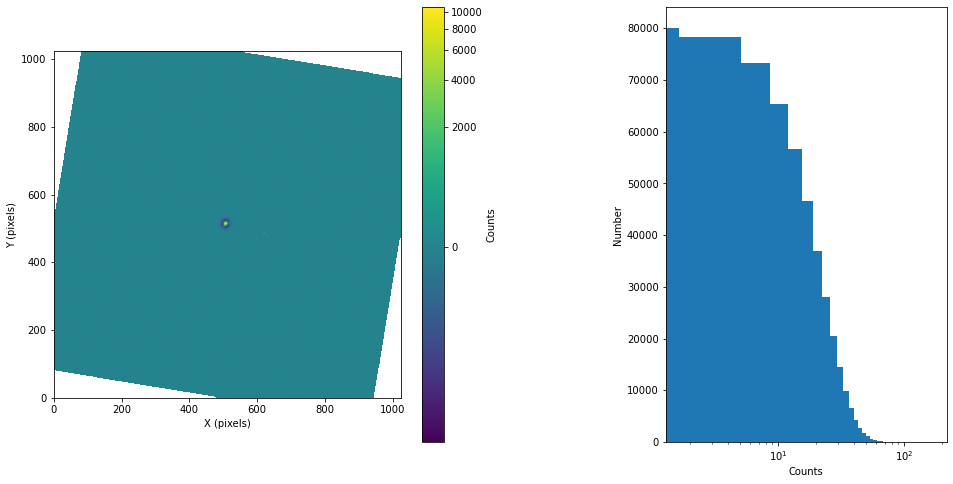

type 'skip' to skip, else type 'go': go


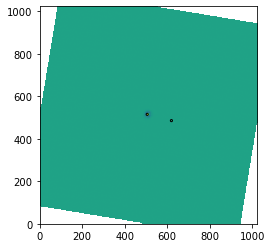

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
619.8421536748474 485.44511628211177 0.10254595707672758
505.9439391482219  514.9113054121327 0.06088073759794754
input the 0 indexed integer of your target from the table above: 1
target star is at  505 , 514  at FWHM 5.663510907122486
505 514
give boxsize: 451



Max x-shift=29.754378764629678, max y-shift=23.07992204821602 (pixels)

 Done stacking!


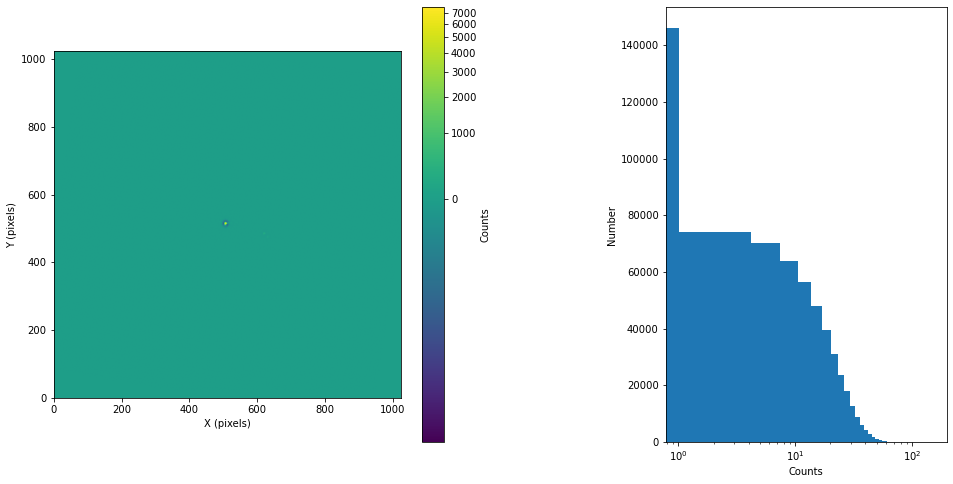

running circular symmetry on:  Theta1_Ori_C_2016-11-17_darksub_cube.fit
505 514 225
dimensions of Data: (250, 450, 450)
100
Out of 51 rows, this many have finished: 
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 
[[-1464876.59689079 -1606920.79844355 -1641407.92284506 ...
  -1850781.99428333 -1198423.08930833 -1189096.65509643]
 [-1583933.62966007 -1510964.15231479 -3685730.31943634 ...
  -2331689.61038096 -1262023.8993316  -1369925.13969255]
 [-3960361.19790697 -2132133.27491317 -3885072.90464383 ...
  -1976651.37287296 -1745427.52732759 -2493574.54835372]
 ...
 [-3292651.17858195 -3363070.72554486 -3591540.92458289 ...
  -1986775.15135316 -1929507.34022424 -1736386.1788324 ]
 [-3684291.65449291 -3228498.28377527 -4003244.57766453 ...
  -1980007.00965479 -1580686.43781735 -1634903.47042581]
 [-3077471.02867228 -3234960.43964918 -3019903.56

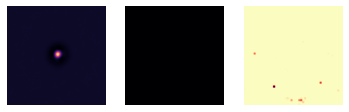

centroid_1dg center: -24.004009871168265 -16.246480445923847

median center of circular symmetry is:  0.49599012883173543 8.25351955407615
median shift all images by:  49.004009871168265 41.24648044592385



----------- o -------------

subdiv into sections len: 125



In [28]:
# high pass filter 

for path in tqdm_notebook(darksubs[19:22]):
    print('current darksubs ind is '+str(darksubs.index(path)))
    # read in darksub cube
    hdr = fits.getheader(path)
    image = fits.getdata(path)
    datadir = path.replace(path.split('\\')[-1], '')
    filname = path.split('\\')[-1]
        
    # register images
    # create guess, boxsize for center of image for registration
    first_im_hp = high_pass_filter(image[0], filtersize=(imdata.shape[0]/15))
    imgandhist(first_im_hp, log=True)
    skip = input('type \'skip\' to skip, else type \'go\': ')
    if skip != 'skip':
        try:
            cenx, ceny, fwhm = findFirst('blah', thresh=100, fwhmguess=5, bright=5, roundness=1, data=first_im_hp)
        except TypeError:
            cenx, ceny, fwhm = (image.shape[1]//2, image.shape[2]//2, 3)
        print(cenx, ceny)
        boxsize = int(input('give boxsize: '))
        n = len(image)
        imnans = np.isnan(image)
        image[imnans] = 0
        # coarse registration, first highpass filter
        coarse = np.zeros((n, image.shape[1], image.shape[2]))
        for i in trange(n):
            coarse[i] = high_pass_filter(image[i], filtersize=(coarse.shape[1]/15))

        coarse = crosscube(coarse, cenx, ceny, box=boxsize, returnmed=False, returncube=True)
        #fits.writeto('test2.fit', coarse, fits.getheader(path), overwrite=True)

        imgandhist(coarse[0], log=True)

        # fine registration
        fine = circlesym(datadir, filname, 'circlesym.fit', data=coarse, box=boxsize, center = [cenx, ceny], center_only=boxsize, save=False)
        hdr = fits.getheader(path)
        hdr.append(('COMMENT', 'aligned with crosscorrelation and center of circular symmetry'), end=True)

        # subdivide observation
        n = len(fine)
        start = 0
        if 9999 > n > 100:
            sections = n // int(str(n)[0])
            stop = sections
        elif n > 1e4:
            sections = n // 5
            stop = sections
        print('subdiv into sections len: '+str(sections))
        subdiv_stack = np.zeros((n, fine.shape[1], fine.shape[2]))
        for i in range(n // sections):
            subdiv = fine[start:stop]
            subdiv_stack[i, :, :] = np.nanmedian(subdiv, axis=0)
            newpath = datadir+filname.replace('.fit', '_subdivtest'+str(i)+'_highpass.fit')
            fits.writeto(newpath, subdiv_stack[i, :, :], hdr, overwrite=True)
            start += sections
            stop += sections
    else:
        pass

Choose a reference star image to create a reference PSF from


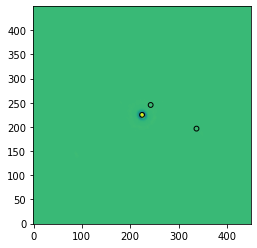

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
 337.1550097944447  196.4676820572476 0.26350148133270845
 224.5419014115595 224.95853084291917 0.24016934494885234
242.32770342118795 245.41302185799952 0.19763608938281566
input the 0 indexed integer of your target from the table above: 1
target star is at  224 , 224  at FWHM 4.865165927438852


C:\Users\willi\Amherst\Thesis\Code\diskShapers\astroCalib\calibFuncs.py:1341: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  plt.imshow(epsf.data, cmap='inferno', origin='lower', norm=norm,


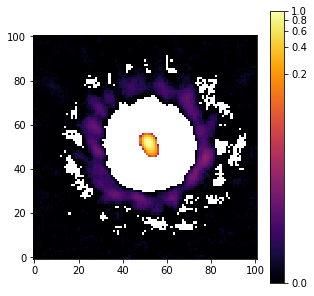

Select your target system to fit positions to


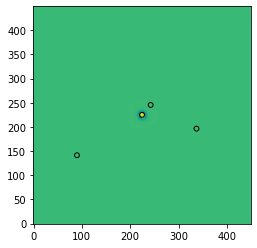

    xcentroid          ycentroid           roundness     
------------------ ------------------ -------------------
  89.8208905551168 141.41683331887154   0.373258573006154
 337.1550097944447  196.4676820572476 0.26350148133270845
 224.5419014115595 224.95853084291917 0.24016934494885234
242.32770342118795 245.41302185799952 0.19763608938281566
input the 0 indexed integer of your target from the table above: 1
target star is at  337 , 196  at FWHM 3.9472142200922917
Stars found at positions
       x_0                y_0        
------------------ ------------------
49.139827377869395 28.456519196794474
       x_0               y_0        
----------------- ------------------
38.31030241482098 38.001842797145265

14.631721037596774 +/- 0.40426553565966883
48.08927813133107 +/- -3.5384910847955666
Choose a reference star image to create a reference PSF from


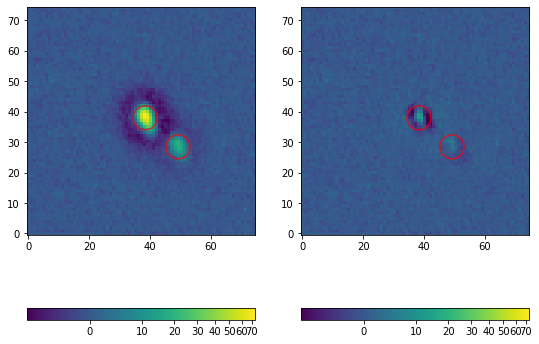

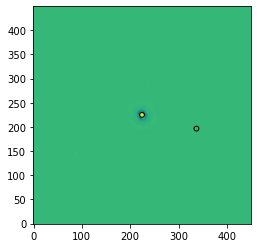

    xcentroid         ycentroid           roundness     
----------------- ------------------ -------------------
337.0638771126471 196.53106205504662 0.19643838452704812
224.4630908507024 224.87468144418705  0.2252744220214115


KeyboardInterrupt: Interrupted by user

In [49]:
import pandas as pd
from astropy.io import fits

data_frames = []
for path in darksubs[40:]:
    datadir = path.replace(path.split('\\')[-1], '')
    dataset = glob.glob(datadir+'*subdivtest*_highpass.fit*')
    data = []
    dates = []
    filts = []
    for image in dataset:
        phot_results = VisAOLocate(image, 7, 5, 5, stampsize=75, epsfstamp=101, roundness=1,
                                  iterations=1, crit_sep=5, setfwhm=5)#, background_sloped=[5,5])
        phot_results = calcBinDist(phot_results, scale='n')
        data.append(phot_results)
        hdr = fits.getheader(image)
        date = hdr['DATE']
        if hdr['VFW1POS'] == 0.0:
                if hdr['VFW2POS'] == 0.0:
                    passband = hdr['VFW3POSN'].replace(' ','-')
                else:
                    passband = hdr['VFW2POSN'].replace('\'', 'prime')
        else:
            passband = hdr['VFW1POSN']
        dates.append(date)
        filts.append(passband)
    data2 = np.asarray(data)
    data_frame = pd.DataFrame(data=data2, columns=['sep','seperr','PA','PAerr'])
    data_frame['date'] = dates
    data_frame['filter'] = filts
    data_frames.append(data_frame)

In [34]:
data_frames

[         sep    seperr         PA     PAerr                 date  filter
 0  14.635422  0.304716  46.681237 -2.517778  2016-11-17T07:31:55  zprime
 1  14.617388  0.298509  46.418402 -2.495674  2016-11-17T07:31:55  zprime]

In [35]:
data_frames[0].to_clipboard()

In [ ]:
# look at Theta 1 Ori C
from astropy.io import fits
from photutils.centroids import centroid_sources
from photutils import CircularAperture
from astropy.stats import sigma_clip

for path in [darksubs[5]]:
    datadir = path.replace(path.split('\\')[-1], '')
    dataset = glob.glob(datadir+'*subdivtest*.fit*')
    for image in dataset:
        img = fits.getdata(image)
        xcens, ycens = centroid_sources(img, [13, 17], [17, 13], box_size=7)

        positions = np.transpose((xcens, ycens))
        apertures = CircularAperture(positions, r=3)

        fig = plt.figure(figsize=(8,4))
        ax1 = plt.subplot2grid((3,6), (0,0), rowspan=3, colspan=3)
        im_frame = ax1.imshow(img, norm=ImageNormalize(stretch=LogStretch()), origin='lower')
        apertures.plot(color='red', lw=1.5, alpha=0.7)
        plt.colorbar(im_frame, ax=ax1)
        ax2 = plt.subplot2grid((3,6), (0,4), rowspan=3, colspan=2)
        ax2.hist(sigma_clip(img.flatten(), sigma=10), bins=100)
        ax2.set_xscale('log')
        plt.show()